In [1]:
%matplotlib inline

In [2]:
import numpy as np
import fitsio as ft
import healpy as hp

import sys
sys.path.insert(0, '/home/mehdi/github/sysnetdev')
sys.path.insert(0, '/home/mehdi/github/LSSutils')

from lssutils.utils import hpix2radec
from lssutils.stats.nnbar import MeanDensity
from lssutils.dataviz import setup_color
from scipy.stats import binned_statistic

import matplotlib.pyplot as plt

from glob import glob

In [3]:
import corner

In [9]:
def hist(ngal, frac, syst, bins):
    ng,_,_ = binned_statistic(syst, ngal, statistic='sum', bins=bins)
    nr,_,_ = binned_statistic(syst, frac, statistic='sum', bins=bins)
    ns,_,_ = binned_statistic(syst, syst, statistic='mean', bins=bins)
    
    #nstd,_,_ = binned_statistic(syst, ngal/frac, statistic=np.std, bins=bins)
    #nmodes,_,_ = binned_statistic(syst, np.ones(syst.size), statistic='count', bins=bins)
    norm = ng.sum()/nr.sum()
    mean = ng/(nr*norm)
    #err = nstd/np.sqrt(nmodes)
    return (ns, mean)

def makehp(hpix, value, nside):
    res_ = np.zeros(12*nside*nside)
    res_[hpix] = value
    return res_

def model(x, theta):
    """ Linear model """
    return x.dot(theta[1:]) + theta[0]


def makehp_wlin(xs, theta, hpix):
    p = [7.26384087, 1.91704688]
    w_s = model(xs, theta)
    w_ = (w_s*p[1])+p[0]
    
    w_w = w_ / w_.mean()
    w_w = w_w.clip(0.5, 2.0)    
    
    return makehp(hpix, w_w, 1024)

In [5]:
#chains = np.load('/home/mehdi/github/linear/chains.npy', allow_pickle=True)
chains_ = np.load('/home/mehdi/data/tanveer/dr9/elg_linear/mcmc_bmzls.npz', allow_pickle=True)
chains = chains_['chain']
chains.shape

(1000, 400, 14)

In [6]:
chains_['x']

array([[3.51872986e-02, 9.30287941e+02, 2.34234948e+01, 2.40059223e+01,
        2.29709665e+01, 2.36317109e+01, 2.41779913e+01, 2.32995673e+01,
        2.16124020e+01, 2.10502022e+01, 1.70255896e+00, 1.92144026e+00,
        1.25883445e+00],
       [3.13575579e-02, 7.04603591e+02, 1.58157649e-01, 1.52575079e-01,
        1.55453326e-01, 1.70408062e-01, 1.60418288e-01, 1.77776073e-01,
        1.66438036e-01, 2.31905759e-01, 2.36057821e-01, 2.30236753e-01,
        1.60482314e-01]])

In [29]:
chains_['y']

array([7.26384087, 1.91704688])

In [23]:
df = ft.read('/home/mehdi/data/rongpu/imaging_sys/tables/nelg_features_bmzls_1024.fits')
print(df.dtype.names)

ngal = makehp(df['hpix'], df['label'], 1024)
syst = makehp(df['hpix'], df['features'][:, 0], 1024)
mask = makehp(df['hpix'], 1.0, 1024) > 0
frac = makehp(df['hpix'], df['fracgood'], 1024)

print(np.percentile(ngal[mask], [2.5, 97.5]))

('features', 'label', 'fracgood', 'hpix')
[ 3.75 11.25]


In [24]:
bins = np.linspace(*np.percentile(syst[mask], [1, 99]), num=9)
bins

array([0.00687821, 0.02525393, 0.04362964, 0.06200535, 0.08038106,
       0.09875677, 0.11713248, 0.13550819, 0.1538839 ])

In [25]:
r = {}

#nbar = MeanDensity(ngal, frac, mask, syst, bins=bins, binning='simple', nbins=8)
#nbar.run()
r['DR9 ELGs'] = hist(ngal[mask], frac[mask], syst[mask], bins)

In [26]:
xs = (df['features'] - chains_['x'][0]) / chains_['x'][1]

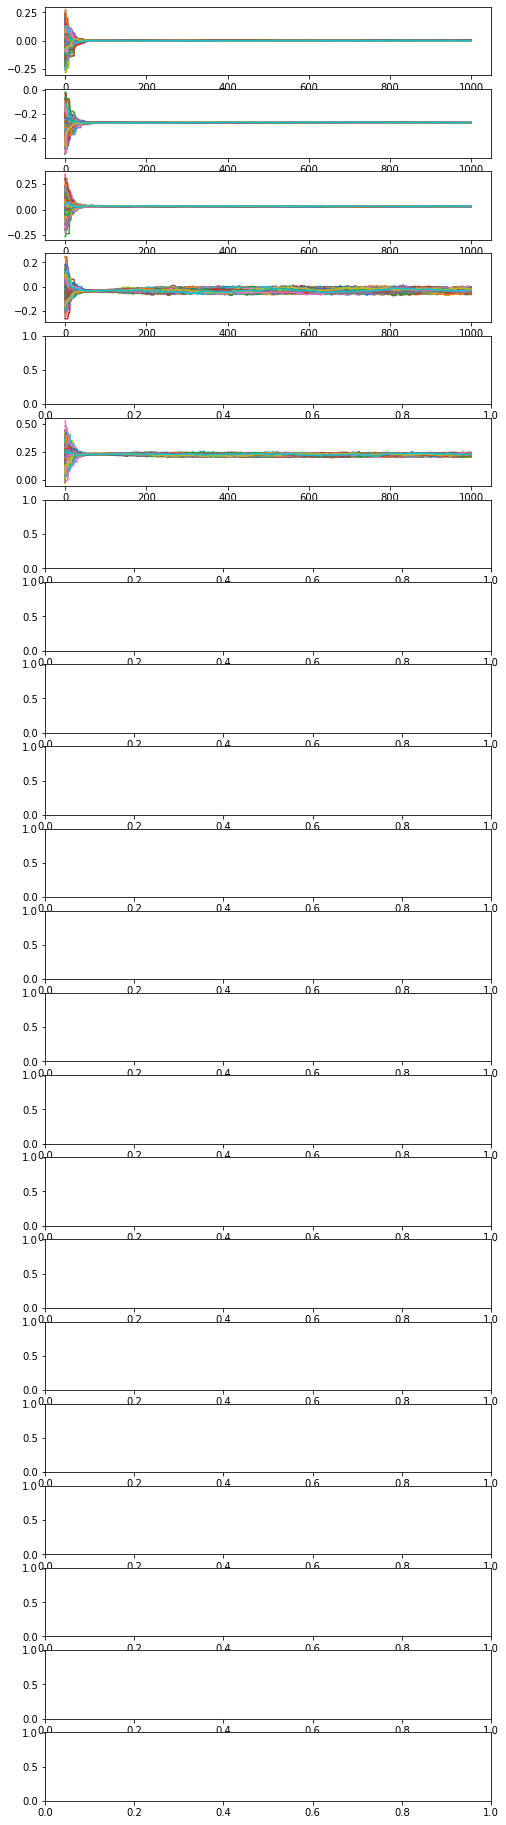

In [10]:
fg, ax = plt.subplots(nrows=22, figsize=(8, 33))
ax = ax.flatten()

for i in [0, 1, 2, 3, 5]:
    for j in range(400):
        ax[i].plot(chains[:, j, i])

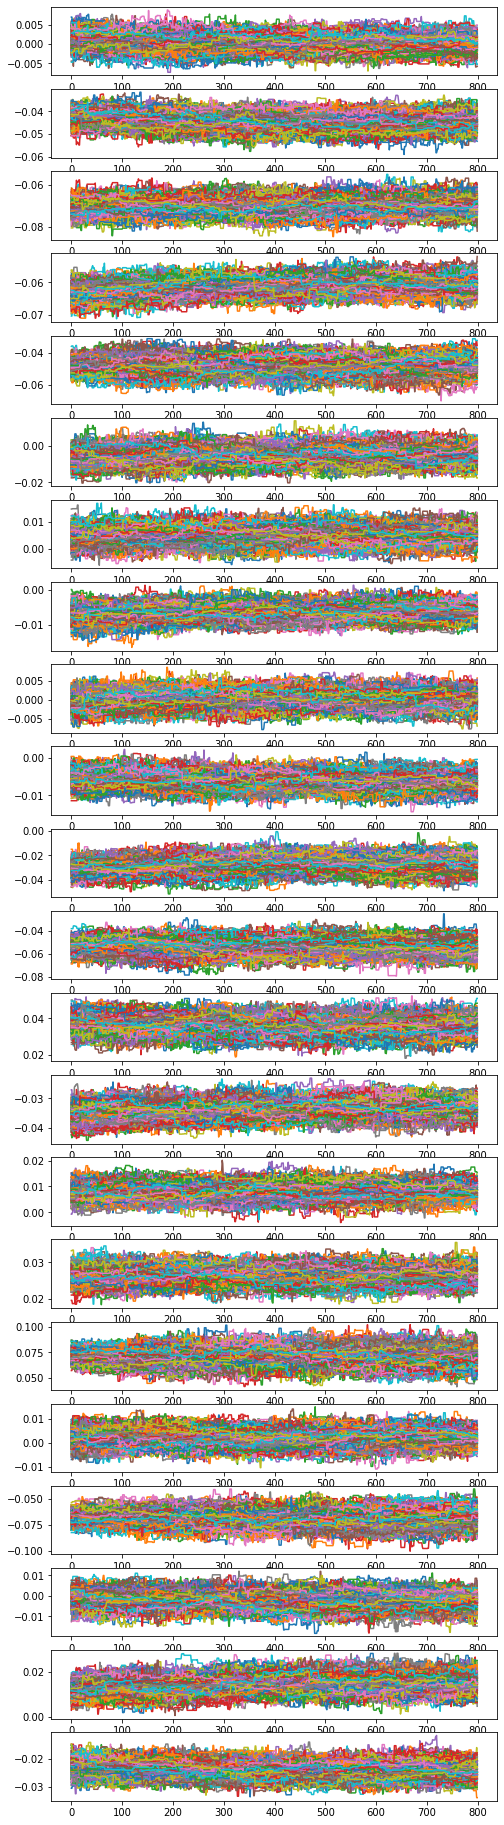

In [7]:
fg, ax = plt.subplots(nrows=22, figsize=(8, 33))
ax = ax.flatten()

for i in range(22):
    for j in range(400):
        ax[i].plot(chains[200:, j, i])

In [12]:
chains_red = chains[100:, :, :]
chains_red = chains_red.reshape(900*400, 14)

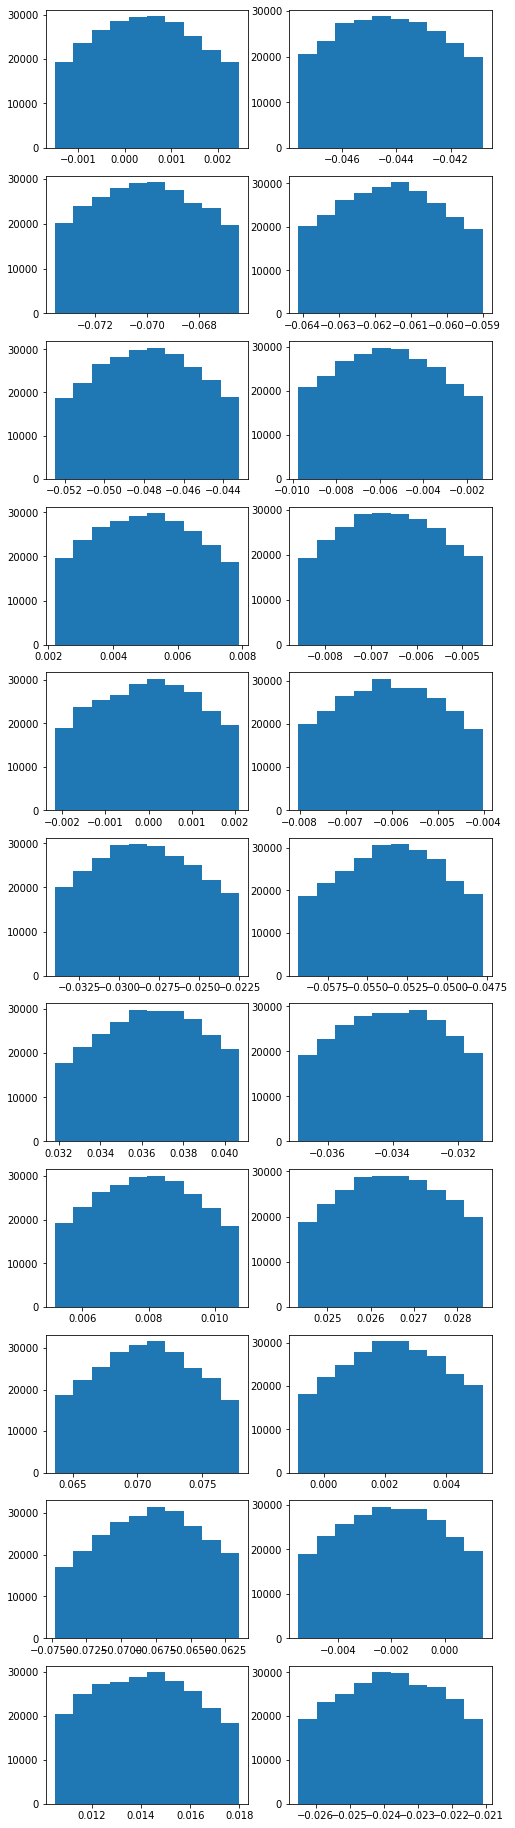

In [10]:
fg, ax = plt.subplots(ncols=2, nrows=11, figsize=(8, 33))
ax = ax.flatten()

for i in range(22):
    min_, max_ = np.percentile(chains_red[:, i], [15., 85.])
    ax[i].hist(chains_red[:, i], range=(min_, max_))

In [27]:
ix = np.random.choice(np.arange(chains_red.shape[0]), size=10, replace=False)

for i in ix:
    whp = makehp_wlin(xs, chains_red[i, :], df['hpix'])
    r['mock_%d'%i] = hist(whp[mask], frac[mask], syst[mask], bins)
    print('.', end='')

..........

Text(0, 0.5, 'Mean Density')

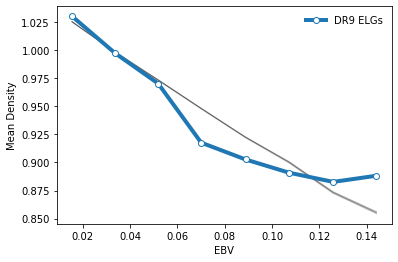

In [28]:
for name, val in r.items():
    #if np.any(val[1] < 0.9):
    #    print(name)
    #    continue
    if name == 'DR9 ELGs':
        plt.plot(val[0], val[1], marker='o', mfc='w', ls='-', label=name, lw=4)
    else:
        plt.plot(val[0], val[1], lw=1, color='k', ls='-', zorder=-1, alpha=0.1)
        
plt.legend(frameon=False)
plt.xlabel('EBV')
plt.ylabel('Mean Density')
# plt.savefig('/home/mehdi/data/tanveer/elg_mse_snapshots/ngal_loghi.png', 
#             dpi=300, bbox_inches='tight')

In [30]:
columns = np.array(['C', 'EBV', 'STARDENS']\
          + [f'galdepth_{b}mag_ebv' for b in ['r', 'g', 'z']]\
          + [f'psfdepth_{b}mag_ebv' for b in ['r', 'g', 'z', 'w1', 'w2']] \
          + [f'PSFSIZE_{b}' for b in ['R', 'G', 'Z']]) # 
len(columns)

14

In [31]:
for i, col in enumerate(columns):
    print(i, col)

0 C
1 EBV
2 STARDENS
3 galdepth_rmag_ebv
4 galdepth_gmag_ebv
5 galdepth_zmag_ebv
6 psfdepth_rmag_ebv
7 psfdepth_gmag_ebv
8 psfdepth_zmag_ebv
9 psfdepth_w1mag_ebv
10 psfdepth_w2mag_ebv
11 PSFSIZE_R
12 PSFSIZE_G
13 PSFSIZE_Z


In [32]:
ix = [0, 1, # c, e[b-v] 
      3, 6, # depth_r, psfdepth_r
      11, 12] # psfsize-r, psfsize-g

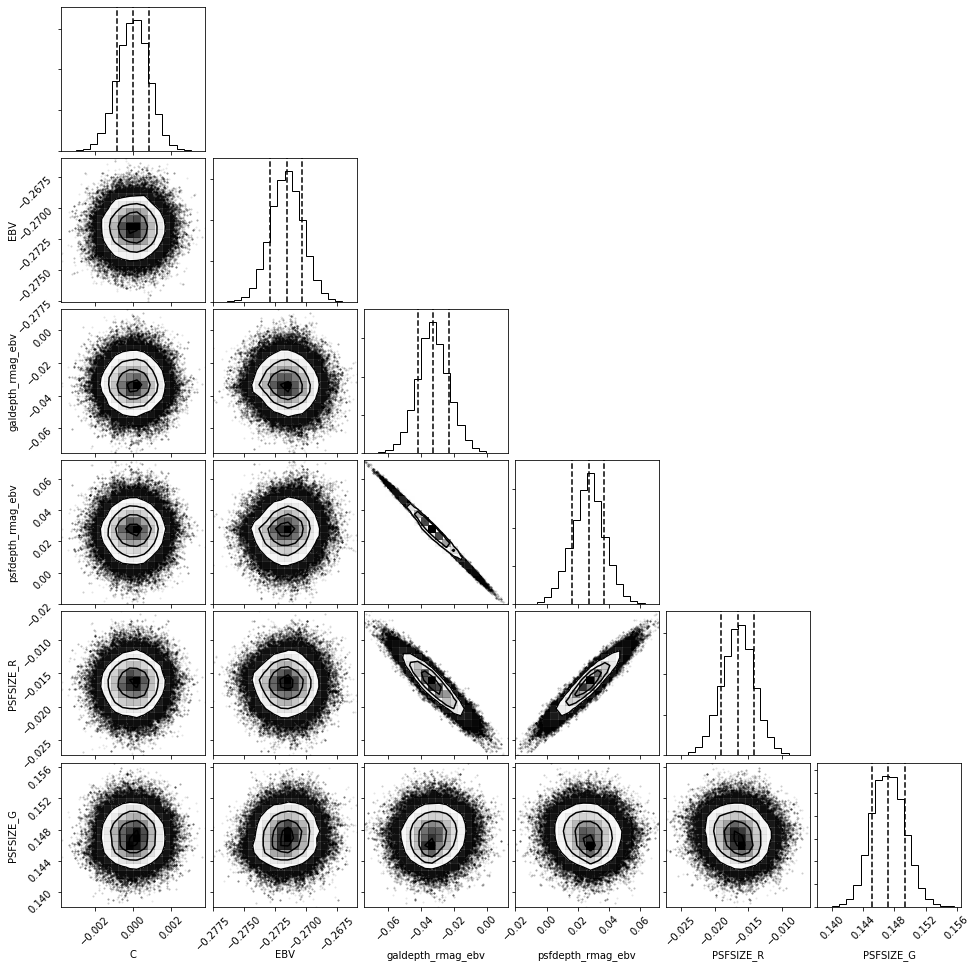

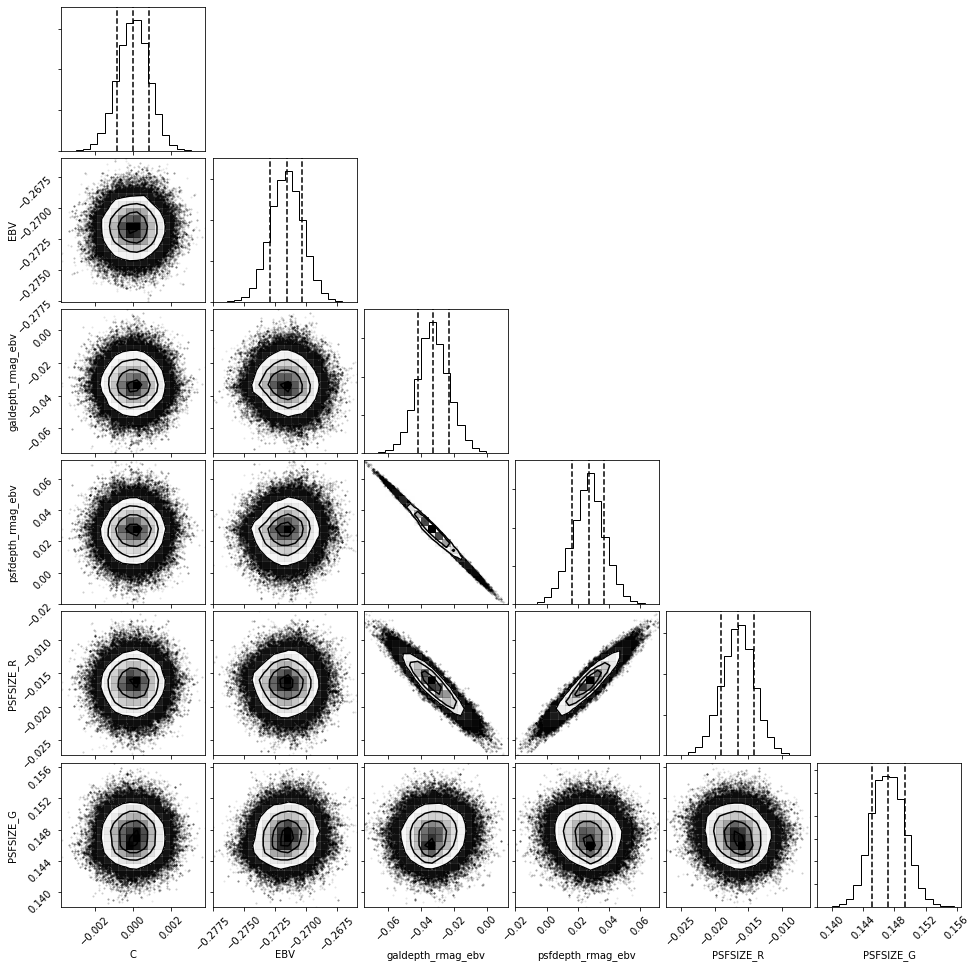

In [33]:
corner.corner(chains_red[:, ix], quantiles=np.array([0.16, 0.5, 0.84]), labels=columns[ix])

In [25]:
# TODO: 
# 1. Find out what subset of these correlate with the Sag. stream
# 2. Cross correlation between the mitigated and imaging C_ell^{g,s} and (C_s,g)^2 / (C_g,g * C_s,s)


# TODO: diagnostics on the chains
# 1. Corner plot to see the correlation between the different parameters
# 2. Rank plot
# 3. Find the best fit and covariance, use those to initialize the starting points
# (make sure these are inside the priors)
# 4. scale the label (y)